# คาดการณ์การจ่ายเงินประกันสุขภาพรายบุคคล

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Lasso , Ridge
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### age : อายุของผู้รับผลประโยชน์
#### sex : เพศของผู้รับผลประโยชน์
#### bmi : ดัชนีมวลกาย 
#### children : จำนวนบุตรของผู้รับผลประโยชน์หลัก
#### smoker : การสูบบุหรี่
#### region : เขตที่อยู่อาศัยของผู้รับผลประโยชน์ในสหรัฐอเมริกา 
#### charges : ค่ารักษาพยาบาลส่วนบุคคลที่เรียกเก็บโดยประกันสุขภาพ

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**ตรวจสอบข้อมูลเบื้องต้น**

In [6]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

**ไม่มีค่าว่างในข้อมูล**

In [7]:
plt.style.use('bmh')

Text(0.5, 1.0, 'Number of Sex')

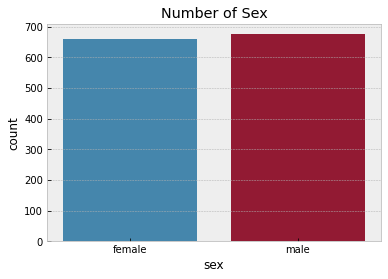

In [8]:
sns.countplot(data=df , x='sex')
plt.title('Number of Sex')

**จำนวนผู้จ่ายเงินประกันสุขภาพ ทั้งชายและหญิงมีจำนวนใกล้เคียงกัน**

Text(0.5, 1.0, 'Number of Smoker by Sex')

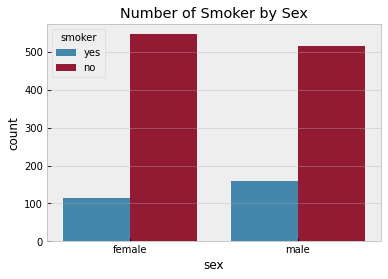

In [9]:
sns.countplot(data=df , x='sex' , hue='smoker')
plt.title('Number of Smoker by Sex')

**เพศชายมีจำนวนคนสูบบุหรี่เยอะกว่าเพศหญิง**

Text(0.5, 1.0, 'Distribution of Charges')

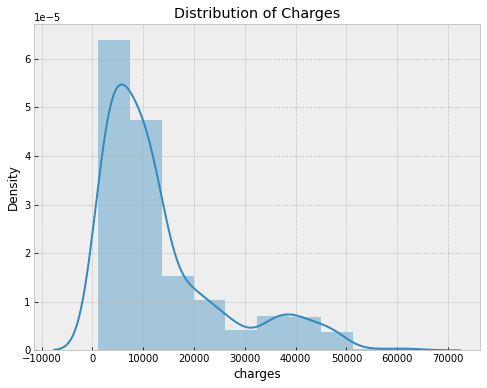

In [10]:
plt.figure(figsize=(8,6))
sns.distplot(df['charges'] , bins=10)
plt.title('Distribution of Charges')

**ค่าใช้จ่ายส่วนมากของเงินประกันสุขภาพอยู่ที่ราวๆ 10000**

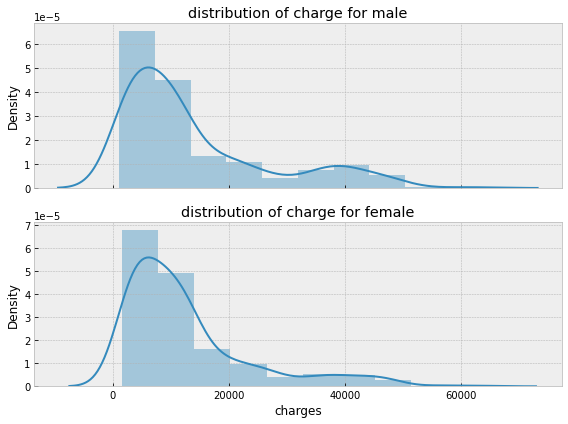

In [11]:
fig , ax = plt.subplots(2,1 , sharex=True  , figsize=(8,6))
#ax = ax.ravel()
sns.distplot(df[df['sex'] == 'male']['charges'] , bins=10 , ax=ax[0])
ax[0].set_title('distribution of charge for male')
sns.distplot(df[df['sex'] == 'female']['charges'] , bins=10, ax=ax[1])
ax[1].set_title('distribution of charge for female')
plt.tight_layout()


**ค่าใช้จ่ายเงินประกันสุขภาพ ของเพศชายและเพศหญิง ไม่ค่อยต่างกันมาก**

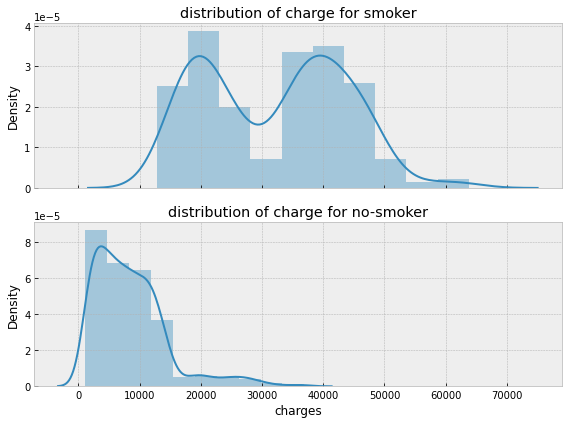

In [12]:
fig , ax = plt.subplots(2,1 , sharex=True, figsize=(8,6))
#ax = ax.ravel()
sns.distplot(df[df['smoker'] == 'yes']['charges'] , bins=10 , ax=ax[0])
ax[0].set_title('distribution of charge for smoker')
sns.distplot(df[df['smoker'] == 'no']['charges'] , bins=10, ax=ax[1])
ax[1].set_title('distribution of charge for no-smoker')
plt.tight_layout()

**ค่าใช้จ่ายเงินประกันสุขภาพ ของผู้ที่สูบบุหรี่ เยอะกว่าผู้ที่ไม่สูบบุหรี่อย่างเห็นได้ชัด**

<AxesSubplot:xlabel='charges', ylabel='sex'>

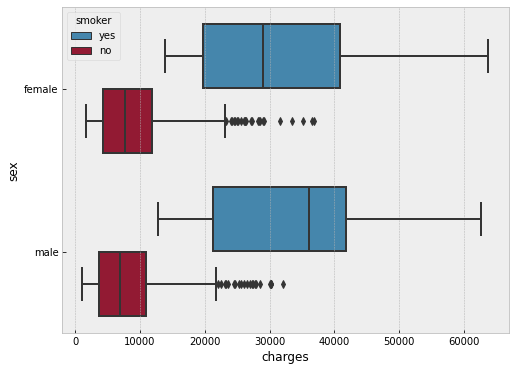

In [13]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df , x='charges' , y='sex' , hue='smoker')

**ค่าใช่จ่ายเงินประกันสุขภาพ ของผู้ที่สูบบุหรี่และไม่สูบบุหรี่ ทั้งเพศชายและหญิง**

Text(0.5, 1.0, 'Distribution of Age')

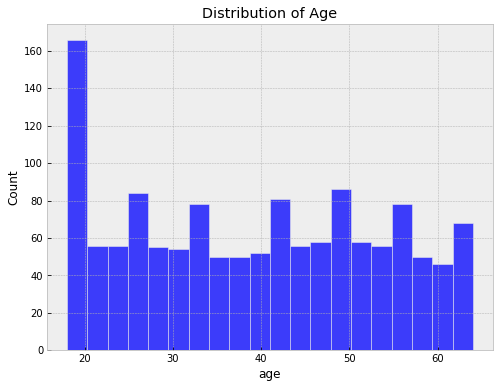

In [14]:
plt.figure(figsize=(8,6))
sns.histplot(df['age'] , bins=20)
plt.title('Distribution of Age')

**ช่วงอายุของผู้จ่ายเงินประกันสุขภาพ โดยจำนวนที่มากที่สุดคือช่วงอายุก่อน 20 ปี**

Text(0.5, 1.0, 'Charges VS. Age')

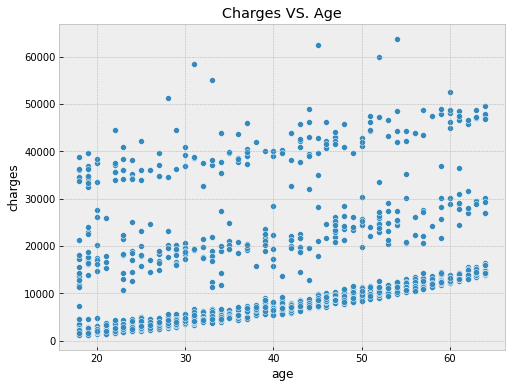

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df , x='age' , y='charges')
plt.title('Charges VS. Age')

**ความสัมพันธ์ของเงินประกันสุขภาพและอายุ**

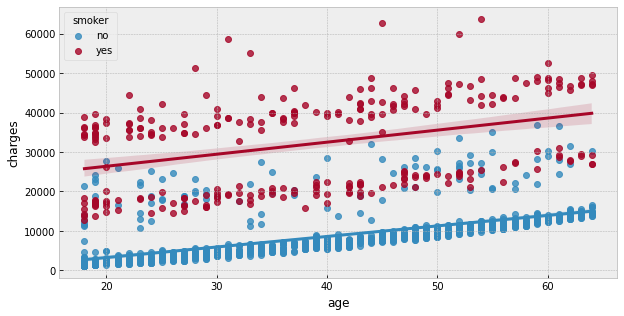

In [16]:
plt.figure(figsize=(10,5))
sns.regplot(data=df[df['smoker'] == 'no'] , x='age' , y='charges' , label='no')
sns.regplot(data=df[df['smoker'] == 'yes'] , x='age' , y='charges' , label='yes')
plt.legend(title='smoker' , loc='upper left')

**ความสัมพันธ์ของเงินประกันสุขภาพและอายุ ระหว่างคนที่สูบบุหรี่และคนที่ไม่สูบบุหรี่\
เห็นได้ชัดเจนว่าคนที่สูบบุหรี่ต้องจ่ายเงินประกันสุขภาพเยอะกว่าปกติ\
ในขณะที่คนที่ไม่สูบบุหรี่โดยส่วนมาก จ่ายเงินประกันสุขภาพมากขึ้นเล็กน้อยตามอายุที่มากขึ้น**

Text(0.5, 1.0, 'Distribution of BMI')

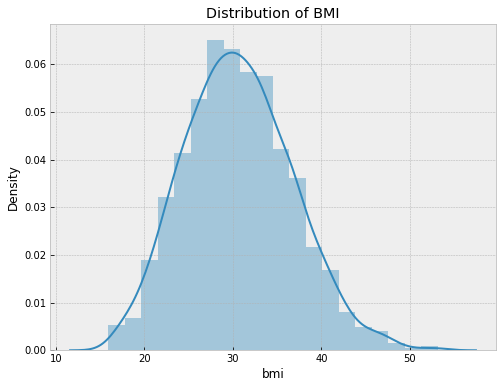

In [17]:
plt.figure(figsize=(8,6))
sns.distplot(df['bmi'] , bins=20)
plt.title('Distribution of BMI')

**ค่าดัชนีมวลกายของผู้จ่ายเงินประกันสุขภาพ โดยเฉลี่ยอยู่ที่ราวๆ 30**

Text(0.5, 1.0, 'Charges VS BMI')

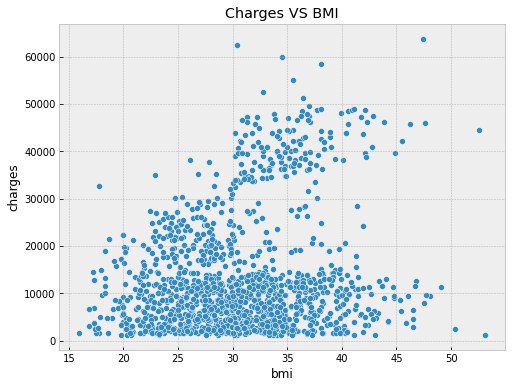

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df , x='bmi' , y='charges')
plt.title('Charges VS BMI')

**ความสัมพันธ์ของเงินประกันสุขภาพกับค่าดัชนีมวลกาย**

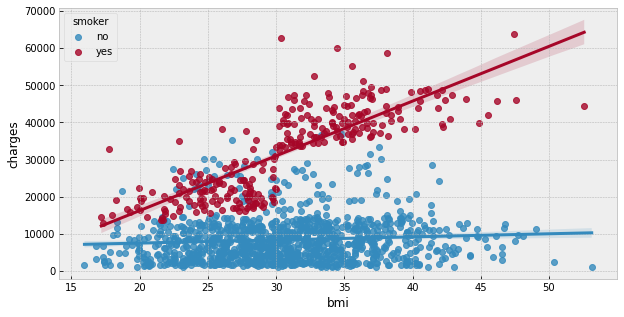

In [19]:
plt.figure(figsize=(10,5))
sns.regplot(data=df[df['smoker'] == 'no'] , x='bmi' , y='charges' , label='no')
sns.regplot(data=df[df['smoker'] == 'yes'] , x='bmi' , y='charges' , label='yes')
plt.legend(title='smoker')

**ความสัมพันธ์ของเงินประกันสุขภาพและอายุ ระหว่างคนที่สูบบุหรี่และคนที่ไม่สูบบุหรี่\
สำหรับผู้ที่ไม่สูบบุหรี่ ค่าดัชนีมวลกายไม่ค่อยมีผลกระทบกับเงินประกันสุขภาพมากนัก\
แต่ผู้ที่สูบบุหรี่ ต้องจ่ายเงินประกันสุขภาพเพิ่มมากขึ้นตามค่าดัชนีมวลกาย**

Text(0.5, 1.0, 'Number of Children')

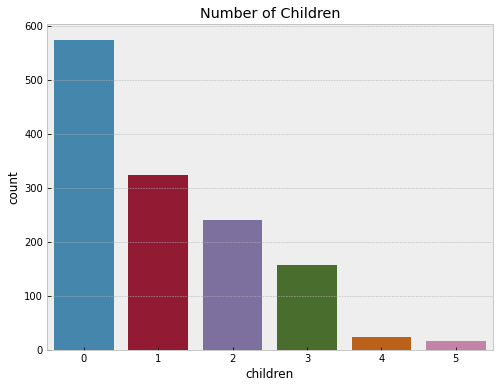

In [20]:
plt.figure(figsize=(8,6))
sns.countplot(data=df , x='children')
plt.title("Number of Children")

**จำนวนลูกของผู้จ่ายเงินประกันสุขภาพ โดยส่วนมากไม่มีลูก**

Text(0.5, 1.0, 'distribution of charges by who have children')

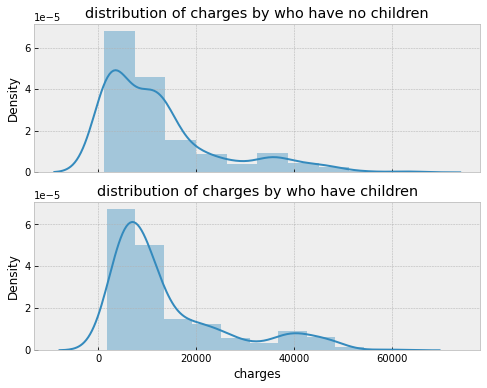

In [21]:
fig , ax = plt.subplots(2,1 , sharex=True, figsize=(8,6))
sns.distplot(df[df['children'] == 0]['charges'] , bins=10 , ax=ax[0])
ax[0].set_title('distribution of charges by who have no children')
sns.distplot(df[df['children'] > 0 ]['charges'] , bins=10 , ax=ax[1])
ax[1].set_title('distribution of charges by who have children')

**ค่าใช้จ่ายเงินประกันสุขภาพของผู้ที่มีลูก สูงกว่าผู้ที่ไม่มีลูกเพียงเล็กน้อย**

In [22]:
df_dum = df.copy()

In [23]:
for i in df_dum.columns :
    if df_dum[i].dtype == 'object' :
        df_dum = pd.concat([df_dum , df_dum[i].str.get_dummies().add_prefix(f'{i}_')] , axis=1)
        df_dum = df_dum.drop(i , axis=1)

In [24]:
df_dum.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


<AxesSubplot:>

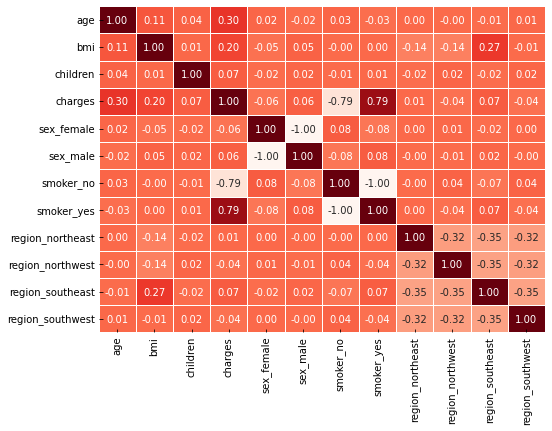

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(df_dum.corr() , annot=True , cmap='Reds' , fmt='0.2f' , cbar=False , linewidths=1)

**จากภาพแสดงความสัมพันธ์ของแต่ละคุณสมบัติ\
ค่าที่มีผลกระทบด้านบวกมากที่สุดต่อเงินประกันสุขภาพคือ ผู้ที่สูบบุหรี่ อายุ ค่าดัชนีมวลกาย\
ค่าที่มีผลกระทบด้านลบมากที่สุดต่อเงินประกันสุขภาพคือ ผู้ที่ไม่สูบบุหรี่\
และค่าที่ไม่มีผลต่อเงินประกันสุขภาพเลยคือ เขตที่อยู่อาศัย**

In [26]:
features = df.drop(['charges' , 'region'] , axis=1)
target = df['charges']

In [27]:
for i in features.columns :
    if features[i].dtype == 'object' :
        features = pd.concat([features , features[i].str.get_dummies().add_prefix(f'{i}_')] , axis=1)
        features = features.drop(i , axis=1)

In [28]:
features.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,0,1,0,0,1
1,18,33.770,1,0,1,1,0
2,28,33.000,3,0,1,1,0
3,33,22.705,0,0,1,1,0
4,32,28.880,0,0,1,1,0


In [29]:
x_train , x_test , y_train , y_test = train_test_split(features , target , test_size=0.2 , random_state=50)

In [30]:
x_train.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes
1048,25,22.515,1,1,0,1,0
45,55,37.300,0,0,1,1,0
201,48,32.230,1,1,0,1,0
153,42,23.370,0,1,0,0,1
1251,19,19.800,0,0,1,1,0


In [31]:
y_train.head()

1048     3594.17085
45      20630.28351
201      8871.15170
153     19964.74630
1251     1241.56500
Name: charges, dtype: float64

In [32]:
def test_degree(degree) :
    pipe = Pipeline([
        ('poly' , PolynomialFeatures(degree=degree)) ,
        ('scale' , StandardScaler()) , 
        ('model' , LinearRegression())
    ])
    pipe.fit(x_train , y_train)
    prediction = pipe.predict(x_test)
    
    return r2_score(y_test , prediction)

**ใช้โมเดล LinearRegression เพื่อหาว่าข้อมูลเป็น LinearRegression หรือ Non-LinearRegression**

In [33]:
test_degree(1)

0.7843146661192301

**LinearRegression(degree=1) ได้ค่า R2=0.7843**

In [34]:
test_degree(2)

0.8629013922568536

**Non-LinearRegression(degree=2) ได้ค่า R2=0.8629\
สรุปได้ว่า ข้อมูลเป็นแบบ Non-LinearRegression**

In [35]:
lis_model = [LinearRegression() , Lasso() , Ridge() , KNeighborsRegressor() , 
             RandomForestRegressor() , GradientBoostingRegressor() ]

In [36]:
lis_score = []
def modeling(model):
    pipeline = Pipeline([
        ('poly' , PolynomialFeatures(degree=2)) ,
        ('scale' , StandardScaler()) , 
        ('model' , model)
    ])
    pipeline.fit(x_train , y_train)
    prediction = pipeline.predict(x_test)
    lis_score.append([
        str(model).replace('()','') ,
        r2_score(y_test , prediction).round(4) ,
        mean_absolute_error(y_test , prediction).round(2) , 
        np.sqrt(mean_squared_error(y_test , prediction)).round(2)
    ])

In [37]:
for model in lis_model :
    modeling(model )

In [38]:
result = pd.DataFrame(lis_score ,columns=['Model', 'R2' , 'MAE' , 'RMSE']).sort_values('R2' , ascending=False)
result

,Model,R2,MAE,RMSE
5,GradientBoostingRegressor,0.8723,2553.72,4524.04
0,LinearRegression,0.8629,2975.85,4687.83
1,Lasso,0.8625,2921.07,4695.33
2,Ridge,0.8623,2918.06,4698.74
4,RandomForestRegressor,0.8478,2766.54,4938.94
3,KNeighborsRegressor,0.8454,2933.42,4978.85


**จากการทดสอบเบื้องต้น โมเดล GradientBoostingRegressor ให้ผลลัพธ์ที่ดีที่สุด**

In [39]:
gbr = GradientBoostingRegressor()

In [40]:
pipe_gbr = Pipeline([
    ('poly' , PolynomialFeatures(degree=2)) ,
    ('scale' , StandardScaler()) , 
    ('model' , gbr)
])

**นำ GradientBoostingRegressor มาหา parameter ที่เหมาะสมที่สุดโดย GridSearchCV**

In [41]:
grid_gbr = GridSearchCV(pipe_gbr , param_grid=dict(model__n_estimators=[50,100,150,200] , 
                                                  model__max_depth = [4,5,6,7] ,
                                                  model__learning_rate=[0.01,0.05,0.1]) , cv=5 , n_jobs=-1 , verbose=1)

In [42]:
grid_gbr.fit(x_train , y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scale', StandardScaler()),
                                       ('model', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [4, 5, 6, 7],
                         'model__n_estimators': [50, 100, 150, 200]},
             verbose=1)

**ขั้นตอนสุดท้าย ทดสอบประสิทธิภาพของโมเดล**

In [43]:
print('best score =',grid_gbr.best_score_)

best score = 0.8485019576658226


In [44]:
print('best parameter =',grid_gbr.best_params_)

best parameter = {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 100}


In [45]:
model = grid_gbr.best_estimator_

In [46]:
print('train score =',model.score(x_train , y_train).round(4))
print('test score =',model.score(x_test , y_test).round(4))

train score = 0.9111
test score = 0.8718


In [47]:
prediction = model.predict(x_test)

In [48]:
print('R2 =',r2_score(y_test , prediction).round(4))
print('MAE =',mean_absolute_error(y_test , prediction).round(4))
print('MSE =',mean_squared_error(y_test , prediction).round(4))
print('RMSE =',np.sqrt(mean_squared_error(y_test , prediction)).round(4))

R2 = 0.8718
MAE = 2558.6385
MSE = 20547936.6505
RMSE = 4532.9832


Text(0, 0.5, 'y_test')

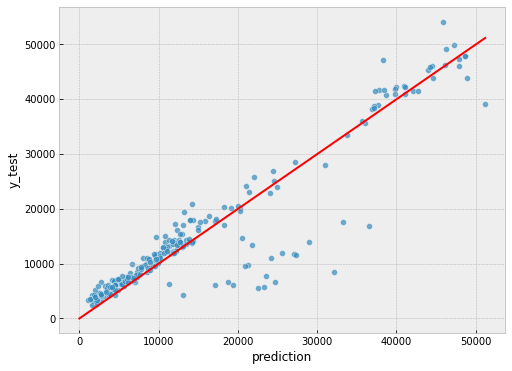

In [49]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1,y_test.max()) , np.arange(1,y_test.max()) , '-' , color='r')
sns.scatterplot(y_test , prediction , alpha=0.7)
plt.xlabel('prediction')
plt.ylabel('y_test')

**จุดสีน้ำเงินคือค่าที่ได้จากการคาดการณ์ เส้นสีแดงคือค่าที่เป็นจริง**

<AxesSubplot:xlabel='charges', ylabel='Density'>

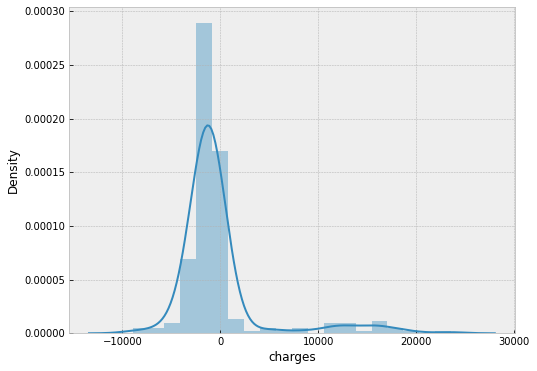

In [50]:
plt.figure(figsize=(8,6))
sns.distplot(y_test - prediction , bins=20)

**ความคลาดเคลื่อนของค่าที่ได้จากการคาดการณ์**